**Description**: Analyzes BERT *or* GPT-2 accuracies for a given number of test
observations (200 or 500).

**Estimated runtime**: ~1 hour (Multi-core isn't working on my machine. Set
`cores=4` in the `model.fit` call if it works for you.)

Note: I'm still learning how to do this type of analysis.

In [1]:
import os
from typing import Literal

import seaborn as sns

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which model and which number of test observations do you want to analyze?

In [3]:
model: Literal["bert", "gpt2"] = "gpt2"
num_test: Literal[200, 500] = 500

# Load data

In [4]:
accuracies_dir = os.path.join("accuracies_from_paper", str(num_test), model)
accuracy_df = utils.load_accuracies(accuracies_dir)

In [5]:
num_correct_df = utils.accuracies_to_num_correct(accuracy_df, num_test)

# Does pretraining help?

This is our control.

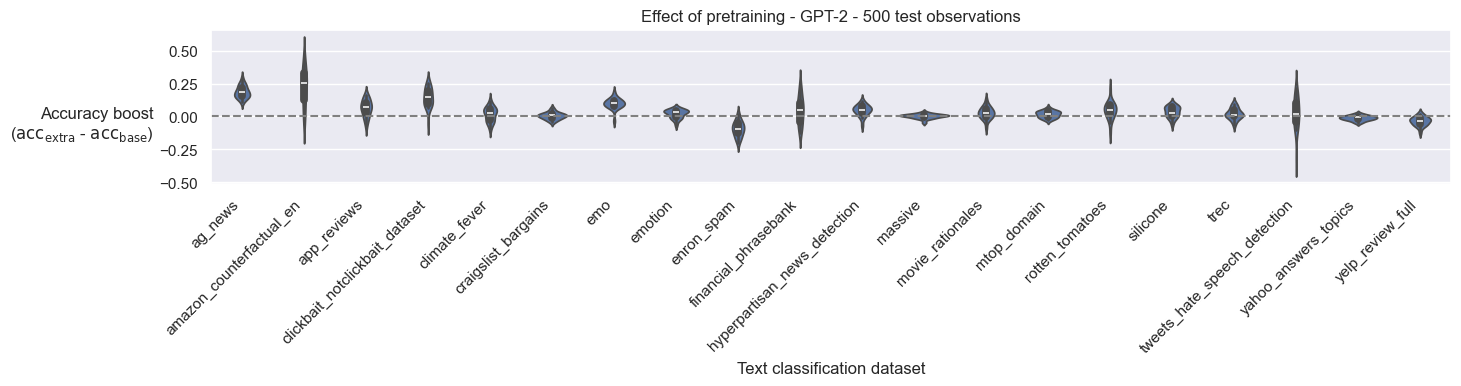

Overall difference:
┌──────────┬──────────┐
│ mean     ┆ std      │
╞══════════╪══════════╡
│ 0.044575 ┆ 0.055384 │
└──────────┴──────────┘


dataset,mean,std
"""ag_news""",0.1877,0.046086
"""amazon_counter…",0.2252,0.141951
"""app_reviews""",0.0635,0.063657
"""clickbait_notc…",0.1426,0.075728
"""climate_fever""",0.0182,0.054525
"""craigslist_bar…",0.0059,0.026105
"""emo""",0.0985,0.042177
"""emotion""",0.0205,0.033111
"""enron_spam""",-0.0935,0.05755
"""financial_phra…",0.0474,0.103532


In [6]:
title = " - ".join(
    [
        "Effect of pretraining",
        utils.lm_type_to_name[model],
        f"{num_test} test observations",
    ]
)
ylabel = "Accuracy boost"
ylabel_kwargs = dict(rotation="horizontal", ha="right", va="top")
utils.eda(
    accuracy_df,
    treatment="extra",
    control="base",
    title=title,
    color=None,
    ylabel=ylabel,
    **ylabel_kwargs,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1018 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[extra],0.115,0.005,0.106,0.125,0.0,0.0,8721.0,2591.0,1.0


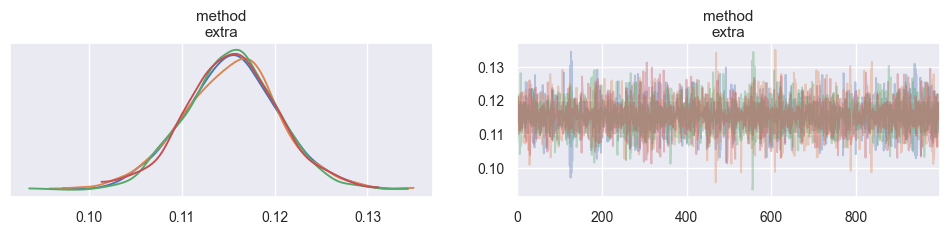

In [7]:
model_control, summary_control, az_summary_control = utils.stat_model(
    num_correct_df, treatment="extra", control="base"
)

In [8]:
print(model_control)

       Formula: num_correct ~ method + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 800
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


Solid evidence that pretraining helps. There's an effect to detect.

# Does pretraining on test cause bias?

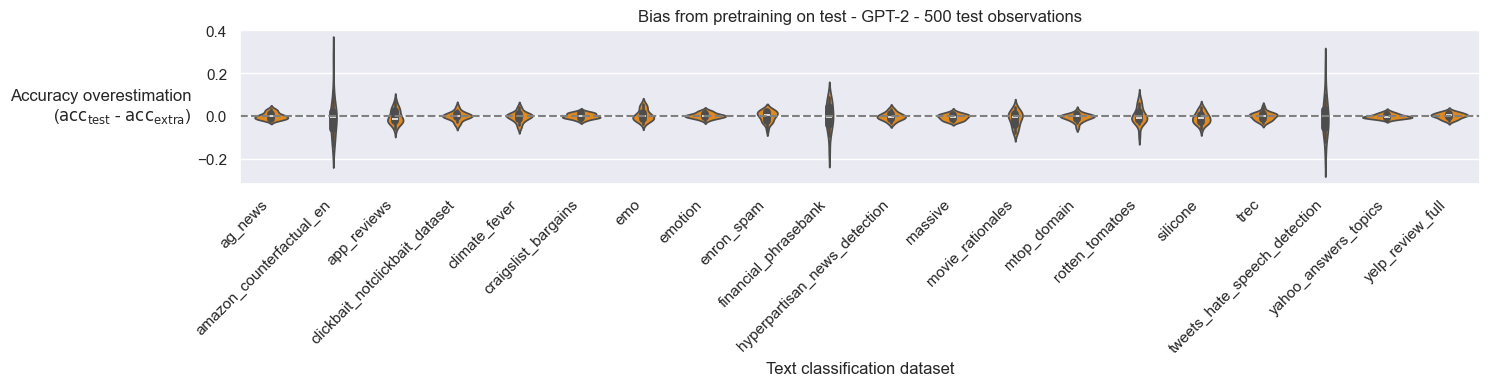

Overall difference:
┌──────────┬──────────┐
│ mean     ┆ std      │
╞══════════╪══════════╡
│ -0.00266 ┆ 0.030274 │
└──────────┴──────────┘


dataset,mean,std
"""ag_news""",0.0003,0.015712
"""amazon_counter…",-0.0055,0.092187
"""app_reviews""",-0.0025,0.033302
"""clickbait_notc…",-0.0007,0.019919
"""climate_fever""",-0.0032,0.022909
"""craigslist_bar…",0.0004,0.012458
"""emo""",0.0036,0.025887
"""emotion""",0.0019,0.01254
"""enron_spam""",-0.0014,0.025316
"""financial_phra…",-0.0042,0.064814


In [9]:
title = " - ".join(
    [
        "Bias from pretraining on test",
        utils.lm_type_to_name[model],
        f"{num_test} test observations",
    ]
)
ylabel = "Accuracy overestimation"
ylabel_kwargs = dict(rotation="horizontal", ha="right", va="center")
utils.eda(
    accuracy_df,
    treatment="test",
    control="extra",
    title=title,
    color="darkorange",
    ylabel=ylabel,
    **ylabel_kwargs,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1043 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[test],-0.006,0.005,-0.016,0.003,0.0,0.0,9888.0,2537.0,1.0


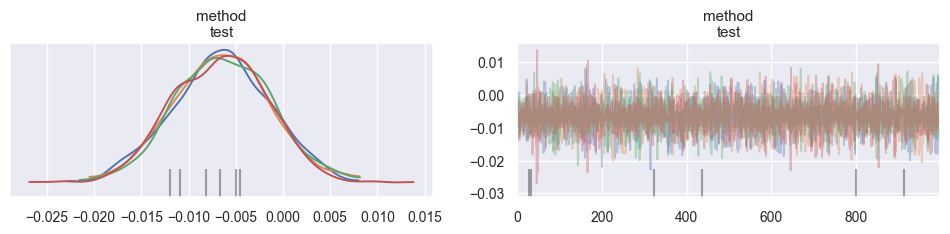

In [10]:
model_bias, summary_bias, az_summary_bias = utils.stat_model(
    num_correct_df, treatment="test", control="extra"
)

In [11]:
print(model_bias)

       Formula: num_correct ~ method + (1|dataset/pair)
        Family: poisson
          Link: mu = log
  Observations: 800
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.5355)
            method ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|dataset ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
            1|dataset:pair ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.5355))
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()


BERT (500): Not good evidence of a bias: $e^{0.003} - 1 \times 100\% \approx 0.3\%$
relative increase in accuracy.

BERT (200): There's evidence of a tiny bias (>90% of the posterior mass is on the right
side): $e^{0.007} - 1 \times 100\% \approx 0.7\%$ relative increase in accuracy.

GPT-2 (500): Bias goes the other way, but kind of noisy. Relunctant to interpret this
result too strongly.

GPT-2 (200): Not good evidence of a bias: $e^{0.003} - 1 \times 100\% \approx 0.3\%$
relative increase in accuracy.

Fun fact: $e^x - 1 \approx x$ for $x \in (-0.01, 0.01)$. Makes it easy to interpret
Poisson models.

I'll re-analyze the combined data, stratifying by model.